# FusionDB reactor browser

Lists all reactors side by side (one column per reactor) with every available field, including derived values. Columns with warnings are highlighted in yellow; mismatches beyond the 1% tolerance are highlighted in red (red overrides yellow). Warning messages are echoed below the table.


In [1]:
from pathlib import Path
import numbers
import time
import warnings
import cProfile
import pstats
import sys

def find_repo_root(start: Path) -> Path:
    for path in (start, *start.parents):
        if (path / 'reactors').is_dir() and (path / 'src' / 'fusdb').is_dir():
            return path
    return start

root = find_repo_root(Path.cwd())
src_path = str(root / 'src')
if src_path not in sys.path:
    sys.path.insert(0, src_path)

import pandas as pd  # Pandas is required for styling
from IPython.display import display

# Import new API
from fusdb.reactor_class import Reactor
from fusdb.variable_class import Variable


In [2]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

PROFILE_TOP = 25
profiler = cProfile.Profile()
profiler.enable()

# Load reactors from YAML format
reactors = {}
computed_flags: dict[tuple[str, str], bool] = {}
input_status: dict[tuple[str, str], str] = {}
warning_messages: dict[str, list[str]] = {}
explicit_params_by_reactor: dict[str, set[str]] = {}
variable_status: dict[tuple[str, str], object] = {}
variable_rank: dict[tuple[str, str], int | None] = {}
relation_status: dict[tuple[str, str], object] = {}

LOG_STAGE_TIMES = True

# Metadata fields
metadata_fields = ['id', 'name', 'organization', 'country', 'year', 'doi', 'notes']

def log(msg: str) -> None:
    print(msg)

def numeric_value(value: object) -> float | None:
    """Extract numeric value from various types."""
    import numpy as np
    try:
        import sympy as sp
    except Exception:
        sp = None
    if isinstance(value, np.ndarray):
        if value.size == 1:
            return float(value.item())
        return None
    if isinstance(value, numbers.Real) and not isinstance(value, bool):
        return float(value)
    if sp is not None and isinstance(value, sp.Expr) and value.is_number:
        try:
            return float(value.evalf())
        except Exception:
            return None
    return None

def to_display_value(value: object) -> object:
    """Convert value to display format."""
    import numpy as np
    try:
        import sympy as sp
    except Exception:
        sp = None
    if isinstance(value, np.ndarray):
        if value.size == 1:
            return float(value.item())
        return f"array({value.size})"
    if sp is not None and isinstance(value, sp.Expr) and value.is_number:
        try:
            return float(value.evalf())
        except Exception:
            return value
    return value

def format_sci(value: object) -> str:
    """Format value for scientific notation if needed."""
    if isinstance(value, str):
        return value
    if isinstance(value, numbers.Real) and not isinstance(value, bool):
        if value != 0 and (abs(value) >= 1e4 or abs(value) <= 1e-4):
            return f"{value:.2e}"
    if value is None:
        return ""
    return str(value)

def exact_match(base: object, other: object, eps: float = 1e-12) -> bool:
    """Check if two numeric values match exactly within epsilon."""
    base_num = numeric_value(base)
    other_num = numeric_value(other)
    if base_num is None or other_num is None:
        return False
    scale = max(abs(base_num), abs(other_num), 1.0)
    return abs(base_num - other_num) <= eps * scale

def classify_input_status(input_val: object, solved_val: object, tol: float = 0.01) -> str:
    """Classify consistency between input and solved values."""
    input_num = numeric_value(input_val)
    solved_num = numeric_value(solved_val)
    if input_num is None or solved_num is None:
        return "none"
    delta = solved_num - input_num
    if delta == 0:
        return "green"
    scale = max(abs(input_num), abs(solved_num), 1.0)
    if abs(delta) <= tol * scale:
        return "yellow"
    return "red"

log(f"Loading reactors from {root.resolve()}")

# Find all reactor directories
reactor_dirs = []
reactors_path = root / 'reactors'
if reactors_path.is_dir():
    for item in reactors_path.iterdir():
        if item.is_dir():
            yaml_path = item / 'reactor.yaml'
            if yaml_path.exists():
                reactor_dirs.append((item, yaml_path))

for reactor_dir, yaml_path in reactor_dirs:
    log(f"Loading {reactor_dir.name} from {yaml_path.name}...")
    t0 = time.perf_counter()
    try:
        reactor = Reactor.from_yaml(yaml_path)
        t_loaded = time.perf_counter()
        try:
            reactor.solve()
        except Exception as e:
            log(f"  ERROR solving reactor: {e}")
        t_solved = time.perf_counter()
    except Exception as e:
        log(f"  ERROR loading reactor: {e}")
        import traceback
        traceback.print_exc()
        continue

    load_elapsed = time.perf_counter() - t0
    log(f"  Loaded reactor in {load_elapsed:.2f}s")
    if LOG_STAGE_TIMES:
        log(f"  - parse/load: {t_loaded - t0:.2f}s")
        log(f"  - solve: {t_solved - t_loaded:.2f}s")

    # Get reactor ID from reactor properties
    reactor_id = reactor.id or reactor_dir.name
    reactors[reactor_id] = reactor

    # Determine which variables were explicitly provided
    explicit_params = {
        name for name, var in reactor.variables_dict.items()
        if var.input_source == "explicit"
    }
    explicit_params_by_reactor[reactor_id] = explicit_params

    # Track which variables were computed vs explicit
    for name, var in reactor.variables_dict.items():
        input_val = var.input_value
        current_val = Variable.get_from_dict(reactor.variables_dict, name, allow_override=True, mode="current")
        computed_present = any(h.get("reason") in ("relation", "solve") for h in var.history)
        computed_flags[(name, reactor_id)] = computed_present
        input_status[(name, reactor_id)] = classify_input_status(input_val, current_val)

    # Capture variable validity status from solver diagnostics
    t_diag = time.perf_counter()
    try:
        diag = reactor.diagnose()
        for name, status, rank in diag["variable_issues"]:
            variable_status[(name, reactor_id)] = status
            variable_rank[(name, reactor_id)] = rank
        for rel_name, status, _residual in diag["violated_relations"]:
            relation_status[(reactor_id, rel_name)] = status
    except Exception as e:
        warning_messages.setdefault(reactor_id, []).append(f"diagnose failed: {e}")
    t_diag_done = time.perf_counter()
    if LOG_STAGE_TIMES:
        log(f"  - diagnostics: {t_diag_done - t_diag:.2f}s")

    warning_messages[reactor_id] = warning_messages.get(reactor_id, [])

profiler.disable()
pstats.Stats(profiler).sort_stats("cumtime").print_stats(PROFILE_TOP)


Loading reactors from /home/alessmor/Scrivania/fusdb
Loading HAMMIR from reactor.yaml...
  Loaded reactor in 1.16s
  - parse/load: 0.68s
  - solve: 0.47s
  - diagnostics: 0.29s
Loading STEP_2024 from reactor.yaml...


/home/alessmor/Scrivania/fusdb/src/fusdb/relationsystem_class.py:282: UserWarning: Inconsistency: relation 'Toroidal beta' computed beta_T = 0.125, but input specifies beta_T = 0.139
  warnings.warn(
/home/alessmor/Scrivania/fusdb/src/fusdb/relationsystem_class.py:282: UserWarning: Inconsistency: relation 'Normalized beta' computed beta_N = 3.92, but input specifies beta_N = 0.0393
  warnings.warn(
/home/alessmor/Scrivania/fusdb/src/fusdb/relationsystem_class.py:1184: UserWarning: Inconsistency: overriding beta_N by 2 -> 3.918942731277534
  warnings.warn(
/home/alessmor/Scrivania/fusdb/src/fusdb/relationsystem_class.py:1184: UserWarning: Inconsistency: overriding beta_T by 0.0462 -> 0.12498212883436052 (global)
  warnings.warn(
/home/alessmor/Scrivania/fusdb/src/fusdb/relationsystem_class.py:1184: UserWarning: Inconsistency: overriding beta_N by 1.95 -> 3.5237252182374776
  warnings.warn(


  Loaded reactor in 18.84s
  - parse/load: 2.00s
  - solve: 16.84s
  - diagnostics: 0.42s
Loading DEMO_2022 from reactor.yaml...


/home/alessmor/Scrivania/fusdb/src/fusdb/relationsystem_class.py:282: UserWarning: Inconsistency: relation 'Total fusion power' computed P_fus = 2.24e+09, but input specifies P_fus = 2e+09
  warnings.warn(
/home/alessmor/Scrivania/fusdb/src/fusdb/relationsystem_class.py:1184: UserWarning: Inconsistency: overriding P_fus by 0.0502 -> 2244914780.432935 (global)
  warnings.warn(


  Loaded reactor in 13.55s
  - parse/load: 3.54s
  - solve: 10.00s
  - diagnostics: 0.43s
Loading INFINITY_TWO from reactor.yaml...
  Loaded reactor in 1.17s
  - parse/load: 0.01s
  - solve: 1.16s
  - diagnostics: 0.22s
Loading STELLARIS from reactor.yaml...


/home/alessmor/Scrivania/fusdb/src/fusdb/relationsystem_class.py:282: UserWarning: Inconsistency: relation 'Total fusion power' computed P_fus = 5.27e+09, but input specifies P_fus = 2.7e+09
  warnings.warn(
/home/alessmor/Scrivania/fusdb/src/fusdb/relationsystem_class.py:1184: UserWarning: Inconsistency: overriding P_fus by 0.29 -> 5265862356.25401 (global)
  warnings.warn(


  Loaded reactor in 4.04s
  - parse/load: 0.62s
  - solve: 3.42s
  - diagnostics: 0.34s
Loading ARC_2015 from reactor.yaml...


/home/alessmor/Scrivania/fusdb/src/fusdb/relationsystem_class.py:282: UserWarning: Inconsistency: relation 'Normalized beta' computed beta_N = 2.53, but input specifies beta_N = 2.59
  warnings.warn(
/home/alessmor/Scrivania/fusdb/src/fusdb/relationsystem_class.py:282: UserWarning: Inconsistency: relation 'Total fusion power' computed P_fus = 4.39e+08, but input specifies P_fus = 5.25e+08
  warnings.warn(
/home/alessmor/Scrivania/fusdb/src/fusdb/relationsystem_class.py:1184: UserWarning: Inconsistency: overriding P_fus by 0.0778 -> 438938547.9246135
  warnings.warn(
/home/alessmor/Scrivania/fusdb/src/fusdb/relationsystem_class.py:1184: UserWarning: Inconsistency: overriding beta_N by 0.00977 -> 2.5323589743589743
  warnings.warn(
/home/alessmor/Scrivania/fusdb/src/fusdb/relationsystem_class.py:1184: UserWarning: Inconsistency: overriding B0 by 0.0216 -> 8.752975069227904 (global)
  warnings.warn(
/home/alessmor/Scrivania/fusdb/src/fusdb/relationsystem_class.py:1184: UserWarning: Incons

  Loaded reactor in 16.12s
  - parse/load: 0.58s
  - solve: 15.55s
  - diagnostics: 0.40s
         93316835 function calls (92188635 primitive calls) in 52.875 seconds

   Ordered by: cumulative time
   List reduced from 4375 to 25 due to restriction <25>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       22    0.000    0.000   57.003    2.591 /home/alessmor/Scrivania/fusdb/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3543(run_code)
 32930/22    1.047    0.000   57.003    2.591 {built-in method builtins.exec}
        6    0.000    0.000   47.445    7.907 /home/alessmor/Scrivania/fusdb/src/fusdb/reactor_class.py:181(solve)
        6    0.003    0.000   47.434    7.906 /home/alessmor/Scrivania/fusdb/src/fusdb/relationsystem_class.py:1065(solve)
288109/163063    1.552    0.000   36.854    0.000 /home/alessmor/Scrivania/fusdb/.venv/lib/python3.10/site-packages/sympy/core/sympify.py:124(sympify)
    31964    1.405    0.000   34.558    0.00

In [3]:
# Build table data
parameter_names = sorted(
    {name for reactor in reactors.values() for name in reactor.variables_dict.keys()},
    key=lambda name: (name.lower(), name),
)
field_names = metadata_fields + parameter_names
log(f"Building table: {len(metadata_fields)} metadata fields, {len(parameter_names)} parameters")
parameter_set = set(parameter_names)

def within_tol(base: object, other: object, rel_tol: float | None, abs_tol: float | None, default_rel: float = 0.01) -> bool:
    """Check if two values are within tolerance."""
    base_num = numeric_value(base)
    other_num = numeric_value(other)
    if base_num is None or other_num is None:
        return False
    if rel_tol is None and abs_tol is None:
        rel = default_rel
        abs_t = 0.0
    else:
        rel = rel_tol or 0.0
        abs_t = abs_tol or 0.0
    scale = max(abs(base_num), abs(other_num), 1.0)
    tol = max(abs_t, rel * scale)
    return abs(base_num - other_num) <= tol

table_data: dict[str, dict[str, object]] = {}
for rid, reactor in sorted(reactors.items()):
    column_data: dict[str, object] = {}
    for name in field_names:
        if name in parameter_set:
            if name not in reactor.variables_dict:
                column_data[name] = ""
                continue
            var = reactor.variables_dict[name]
            computed_vals = var.values if var.values else []
            value_0 = computed_vals[0] if computed_vals else None
            value_n = next((v for v in reversed(computed_vals) if v is not None), None)
            if value_0 is None:
                cell_text = ""
            else:
                base_str = format_sci(to_display_value(value_0))
                if value_n is not None and not exact_match(value_0, value_n):
                    last_str = format_sci(to_display_value(value_n))
                    cell_text = f"{base_str} → {last_str}"
                else:
                    cell_text = base_str
            column_data[name] = cell_text
        else:
            column_data[name] = format_sci(getattr(reactor, name, None))
    table_data[rid] = column_data

df = pd.DataFrame.from_dict(table_data, orient="columns")
df = df.reindex(index=field_names, columns=sorted(reactors.keys()))
if len(df.columns) != len(reactors):
    log(f"WARNING: expected {len(reactors)} reactor columns, got {len(df.columns)}")

def style_cells(data: pd.DataFrame) -> pd.DataFrame:
    """Style cells based on input/computed status and value consistency."""
    styles = pd.DataFrame('', index=data.index, columns=data.columns)
    for field in styles.index:
        for rid in styles.columns:
            parts = ['white-space: pre-line;']
            var = reactors[rid].variables_dict.get(field)
            if var is None:
                styles.loc[field, rid] = ' '.join(parts)
                continue
            computed_present = computed_flags.get((field, rid), False)
            values = var.values if var.values else []
            value_0 = values[0] if values else None
            value_n = next((v for v in reversed(values) if v is not None), None)
            if var.input_source is not None and value_0 is not None:
                if value_n is None:
                    parts.append('color: #0a7d2a;')
                elif exact_match(value_0, value_n):
                    parts.append('color: #0a7d2a;')
                elif within_tol(value_0, value_n, var.rel_tol, var.abs_tol):
                    parts.append('color: #b58900;')
                else:
                    parts.append('color: #b30000; font-weight: 600;')
            if computed_present and value_0 is not None:
                parts.append('text-decoration: underline;')
            styles.loc[field, rid] = ' '.join(parts)
    return styles

styled = df.style.apply(style_cells, axis=None)
styled = styled.format(escape=None)
display(styled)

# Show warnings below the table
for rid, msgs in warning_messages.items():
    if not msgs:
        continue
    print(f'Warnings for {rid}:')
    for msg in msgs:
        print(f' - {msg}')

Building table: 7 metadata fields, 100 parameters


,ARC_2015,DEMO_2022,Hammir2024,InfinityTwo2025,STEP2024EBCC,Stellaris2025
id,ARC_2015,DEMO_2022,Hammir2024,InfinityTwo2025,STEP2024EBCC,Stellaris2025
name,ARC 2015,EU-DEMO 2022,Hammir 2024,INFINITY TWO 2025,STEP 2024 EB-CC,Stellaris 2025 - Point A
organization,MIT,EUROFUSION,Realta,TypeOne Energy,UKAEA,Proxima
country,United States,EUU,,,United Kingdom,
year,2015,2022,2024,2025,2024,2025
doi,10.1016/j.fusengdes.2015.07.008,10.1016/j.fusengdes.2022.113080,10.1088/1741-4326/ad3fcb,10.1017/S0022377825000364,10.1088/1741-4326/ad6ea2,10.1016/j.fusengdes.2025.114868
notes,Conceptual compact tokamak from MIT,EU-DEMO Physics Baseline 2022,,,Refers to EC+EBW heating scenario with Conservative Confinement conditions,
A,2.92,3.1,,3.125,1.8,9.8
a,1.13,2.9,,2.0,2.0,1.3
A_p,232.37218811842646,1554.4050448854432,,,600.3569688145529,327


In [4]:
# Display reactor info using the new __repr__ method
print("Loaded reactors:")
for rid, reactor in sorted(reactors.items()):
    print(f"  {reactor}")


Loaded reactors:
  Reactor(id='ARC_2015', name='ARC 2015', org='MIT', year=2015, 86 variables, 86 relations)
  Reactor(id='DEMO_2022', name='EU-DEMO 2022', org='EUROFUSION', year=2022, 82 variables, 86 relations)
  Reactor(id='Hammir2024', name='Hammir 2024', org='Realta', year=2024, 46 variables, 76 relations)
  Reactor(id='InfinityTwo2025', name='INFINITY TWO 2025', org='TypeOne Energy', year=2025, 29 variables, 77 relations)
  Reactor(id='STEP2024EBCC', name='STEP 2024 EB-CC', org='UKAEA', year=2024, 78 variables, 88 relations)
  Reactor(id='Stellaris2025', name='Stellaris 2025 - Point A', org='Proxima', year=2025, 72 variables, 77 relations)


In [5]:
# Prepare reactors for plotting (use all loaded reactors)
plot_reactors = reactors
log(f"Plotting all reactors: {', '.join(sorted(plot_reactors))}")


Plotting all reactors: ARC_2015, DEMO_2022, Hammir2024, InfinityTwo2025, STEP2024EBCC, Stellaris2025


Skipping Hammir2024: Missing 95% geometry variables for plotting: R, a, kappa_95, delta_95
Skipping InfinityTwo2025: Missing 95% geometry variables for plotting: kappa_95, delta_95
Skipping Stellaris2025: Missing 95% geometry variables for plotting: kappa_95, delta_95


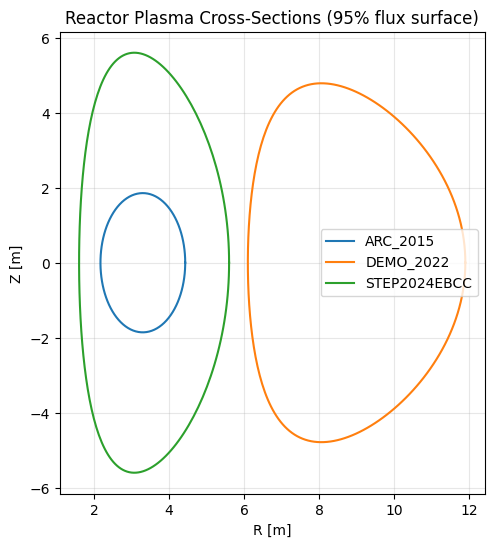

In [6]:
# Plot plasma cross-sections for all loaded reactors
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 6))
plotted = 0

for name, reactor in sorted(plot_reactors.items()):
    try:
        reactor.plot_cross_sections(ax=ax, label=name)
        plotted += 1
    except Exception as e:
        log(f"Skipping {name}: {e}")

if plotted:
    ax.legend()
    plt.title('Reactor Plasma Cross-Sections (95% flux surface)')
    plt.show()
else:
    log("No reactors had sufficient geometry data to plot.")
